### Impute Data to get rid of outliers (Step 13)
#### Author: S. Sakib Hasan

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
os.chdir(os.path.join(os.getcwd(), "..", "..", "data"));

In [3]:
df = pd.read_csv("combined-season-data.csv", index_col=False);

In [4]:
df.head()

,season,GW,at_home,player_id,team_id,opponent_id,champion_ls,top5_ls,bottom5_ls,promoted_ts,...,threat_rlf,threat_rsf,total_points_pgw,total_points_rlf,total_points_rsf,yellow_cards,yellow_cards_pgw,yellow_cards_rlf,yellow_cards_rsf,total_points
0,2016,1,0,1,20,4,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0
1,2016,1,1,2,6,17,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,1.0
2,2016,1,1,4,1,9,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,2.0
3,2016,1,0,6,18,13,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0
4,2016,1,1,7,4,20,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0


In [5]:
df.tail()

,season,GW,at_home,player_id,team_id,opponent_id,champion_ls,top5_ls,bottom5_ls,promoted_ts,...,threat_rlf,threat_rsf,total_points_pgw,total_points_rlf,total_points_rsf,yellow_cards,yellow_cards_pgw,yellow_cards_rlf,yellow_cards_rsf,total_points
76701,2019,16,1,1224,28,29,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0,0.0,0,0,0.0
76702,2019,16,1,1225,17,3,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,1.0
76703,2019,16,1,1226,21,26,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0
76704,2019,16,1,1227,27,8,0,0,0,0,...,0.0,0.0,2.0,0.0,0.0,1,0.0,0,0,1.0
76705,2019,16,1,1228,27,8,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0


In [6]:
df.isnull().sum().sum()

0

In [7]:
df.duplicated().sum()

0

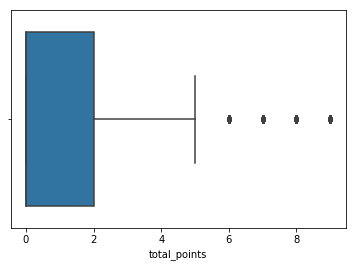

In [8]:
sns.boxplot(x=df['total_points'])

(array([43094., 12010., 10609.,  2930.,   811.,  1421.,  2853.,  1197.,
         1047.,   734.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

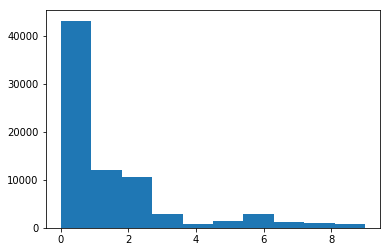

In [9]:
plt.hist(df["total_points"])

In [10]:
distribution_df = pd.DataFrame();

In [11]:
distribution_df["points"] = np.unique(df["total_points"])

In [12]:
def countPoints(point):
    return df[df["total_points"] == point].shape[0]

In [13]:
distribution_df["data_count"] = distribution_df["points"].apply(lambda point: countPoints(point))

In [14]:
distribution_df["data_percent"] = distribution_df["data_count"].apply(lambda count: round(count / df.shape[0] * 100, 3))

In [15]:
distribution_df

,points,data_count,data_percent
0,0.0,43094,56.181
1,1.0,12010,15.657
2,2.0,10609,13.831
3,3.0,2930,3.820
4,4.0,811,1.057
5,5.0,1421,1.853
6,6.0,2853,3.719
7,7.0,1197,1.561
8,8.0,1047,1.365
9,9.0,734,0.957


In [16]:
imputer = KNNImputer()

In [17]:
outlier_threshold = 500;

In [18]:
outlier_points = list(distribution_df[distribution_df["data_count"] <= outlier_threshold]["points"])

In [19]:
def impute_outlier(outlier_points):
    for point in outlier_points:
        total_points = "total_points";
        player_id = "player_id";
        opponent_id = "opponent_id";
        at_home = "at_home";
        season = "season";
        gw = "GW";

        # get the overall df based on the current outlier point
        overall_df = df[df[total_points] == point];

        for index, row in overall_df.iterrows():
            cond1 = (df[player_id] == row[player_id]) & (df[opponent_id] == row[opponent_id]) & (df[at_home] == row[at_home])
            cond2 = (df[player_id] == row[player_id]) & (df[opponent_id] == row[opponent_id])
            cond3 = (df[player_id] == row[player_id])

            lookup_df = df[cond1]
            cond = cond1
            impute_cond = 1

            if lookup_df.shape[0] == 1 or len(np.unique(list(lookup_df[total_points]))) == 1:
                lookup_df = df[cond2]
                cond = cond2
                impute_cond = 2
            if lookup_df.shape[0] == 1 or len(np.unique(list(lookup_df[total_points]))) == 1:
                lookup_df = df[cond3]
                cond = cond3
                impute_cond = 3
            if lookup_df.shape[0] == 1 or len(np.unique(list(lookup_df[total_points]))) == 1:
                break;

            # set the total point at that index to null
            df.at[index, total_points] = None
            lookup_df = df[cond]

            impute_df = pd.DataFrame(data=imputer.fit_transform(lookup_df), columns=df.columns)
            full_cond_impute_df = (impute_df[season] == row[season]) & (impute_df[gw] == row[gw]);

            if impute_cond == 1:
                full_cond_impute_df = full_cond_impute_df & (impute_df[player_id] == row[player_id]) & (impute_df[opponent_id] == row[opponent_id]) & (impute_df[at_home] == row[at_home])
            elif impute_cond == 2:
                full_cond_impute_df = full_cond_impute_df & (impute_df[player_id] == row[player_id]) & (impute_df[opponent_id] == row[opponent_id])
            elif impute_cond == 3:
                full_cond_impute_df = full_cond_impute_df & (impute_df[player_id] == row[player_id])

            full_cond_df = (cond) & (df[season] == row[season]) & (df[gw] == row[gw])
            df.loc[full_cond_df, total_points] = round(impute_df[full_cond_impute_df].iloc[0][total_points], 0)

        print("Done imputing outlier point {}".format(point));

In [20]:
def refresh_distribution():
    distribution_df = pd.DataFrame();
    distribution_df["points"] = np.unique(df["total_points"])
    distribution_df["data_count"] = distribution_df["points"].apply(lambda point: countPoints(point))
    distribution_df["data_percent"] = distribution_df["data_count"].apply(lambda count: round(count / df.shape[0] * 100, 3));
    return distribution_df;

In [21]:
while len(outlier_points) > 0:
    print("Current outlier points: ", outlier_points);
    if (len(outlier_points) == 1):
        outlier = outlier_points[0]
        df = df[df["total_points"] != outlier]
    else: 
        impute_outlier(outlier_points);
        distribution_df = refresh_distribution();
        outlier_points = list(distribution_df[distribution_df["data_count"] <= outlier_threshold]["points"])

In [23]:
distribution_df = refresh_distribution();

In [24]:
distribution_df

,points,data_count,data_percent
0,0.0,43094,56.181
1,1.0,12010,15.657
2,2.0,10609,13.831
3,3.0,2930,3.820
4,4.0,811,1.057
5,5.0,1421,1.853
6,6.0,2853,3.719
7,7.0,1197,1.561
8,8.0,1047,1.365
9,9.0,734,0.957


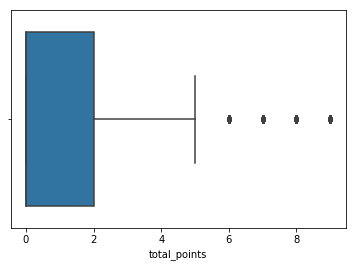

In [25]:
sns.boxplot(x=df['total_points'])

In [26]:
df.shape

(76706, 89)

In [27]:
df.to_csv("combined-season-data.csv", index=False);
df.to_csv("combined-season-data-impute.csv", index=False);